In [1]:
# импортируем необходимые библиотеки

from scipy.spatial.distance import pdist,squareform
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


#from nltk.metrics import edit_distance
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

d:\Eneca\task2\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [212]:
model= SentenceTransformer('distiluse-base-multilingual-cased')

In [213]:
real_parts=['Здание котельной одноэтажное с встроенным двухэтажным АБК и одноэтажными пристройками, включающими оперативные бункеры с гидравлическими толкателями, помещение топливоподачи и навес для твердого топлива.',
 'В осях 1-6, А-Ж имеет простую форму в плане с общими размерами 30,0х30,0 м  и  высотой до низа несущих конструкций покрытия  10,17 м с пристройкой помещений приемки топлива с отметкой до низа строительных конструкций 7,500 м.',
 'Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.',
 'Проектируемая молочно-товарная ферма доильно-молочного блока.',
 'Каркас котельной смешанный из сборных железобетонных колонн с покрытием из металлических конструкций. Шаг колонн 6 м и 9 м, пролеты 24 м и 6 м.',
 'АБК в осях 1-2, А-Г запроектирован двухэтажным без подвала с размерами в плане 6,0х12,0 м с высотой этажа 3,3 м. ',
 'Пристройки в осях 6-14, А-Е имеют сложную форму в плане с общими габаритными размерами 32,8х24,1 м. Отметка низа покрытия помещений приемки топлива плюс 6,900.',
 'Наружные стены  и кровля котельной с АБК предусмотрены из легких трехслойных металлических панелей типа «Сэндвич».',
 'Сопряжение металлических надколонников со сборными железобетонными колоннами и монолитными стенами является жёстким. Соединение металлических ферм и балок с надколонниками выполнено шарнирным.',
 'Устойчивость каркаса достигается за счет жесткого соединения монолитных фундаментов с железобетонными сборными колоннами с шарнирным опиранием стропильных конструкций в поперечном направлении, вертикальными связями и распорками по верху колонн - в продольном направлении. Горизонтальная жесткость обеспечивается за счет связей по верхним и нижним поясам ферм.',
 'Балки покрытия выполнены из горячекатаных металлоконструкций двутаврового сечения, стропильные фермы по серии 1.460.3-23.98 из замкнутых гнутосварных профилей.',
 'Сборные железобетонные колонны по оси 1 сечением 400х400 по серии 1.423.1-3/88, в осях 2-6 сечением 500х400 по серии 1.423.1-5/88.',
 'Перекрытия в осях 1-2, Б-Г выполнены из многопустотных железобетонных плит по серии 1.041-3 с монолитными участками по сборным железобетонным ригелям по серии 1.020-1/87.']

In [214]:
embeddings = model.encode(real_parts)
print(embeddings.shape)


similarities = model.similarity(embeddings, embeddings)
print(similarities.shape)

(13, 512)
torch.Size([13, 13])


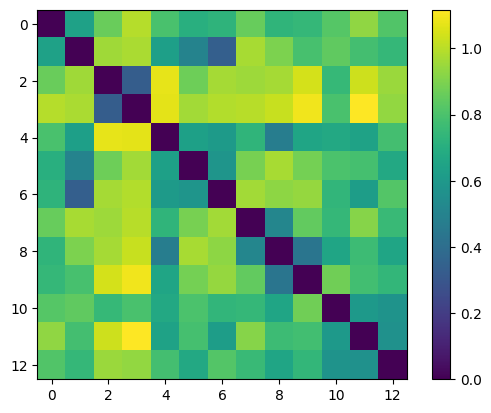

In [216]:
matrix = np.vstack(embeddings)

# Расчет евклидового расстояния между векторами
distances = cdist(matrix, matrix, 'cosine')
# Построение графика
plt.imshow(distances)
plt.colorbar()
plt.show()


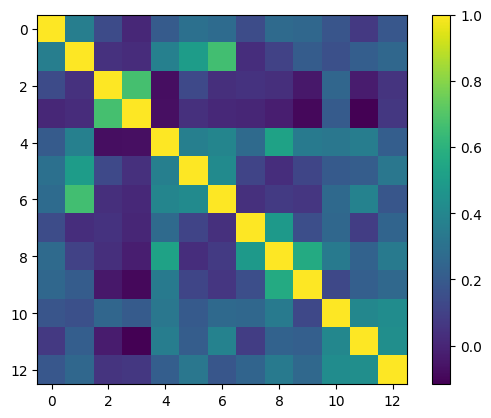

In [217]:
distances = similarities

# Построение графика
plt.imshow(distances)
plt.colorbar()
plt.show()

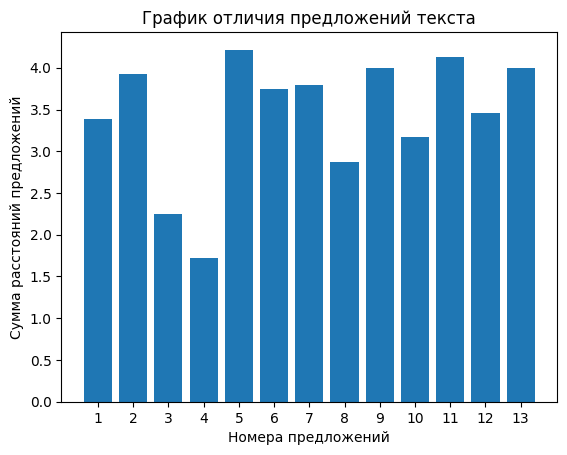

In [218]:
column_sums = np.sum(np.array(distances),axis=0)
# Построение столбчатой диаграммы с измененной нумерацией по оси x
plt.bar(np.arange(1, len(column_sums) + 1), column_sums)
plt.xlabel('Номера предложений')
plt.ylabel('Сумма расстояний предложений')
plt.title('График отличия предложений текста')
plt.xticks(np.arange(1, len(column_sums) + 1))
plt.show()

In [219]:
import statistics as stat

mean=stat.mean(column_sums)
up_bound=mean + stat.stdev(column_sums)
low_bound=mean - stat.stdev(column_sums)
print(mean,low_bound,up_bound)
rez=[list(column_sums).index(i) for i in column_sums if i < low_bound]
rez

3.4354002 2.677218547573641 4.1935819475740646


[2, 3]

In [220]:
for i in rez:
    print(real_parts[i])

Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.
Проектируемая молочно-товарная ферма доильно-молочного блока.


## Добавим больше непохожих предложений

In [221]:
real_parts1=['Здание котельной одноэтажное с встроенным двухэтажным АБК и одноэтажными пристройками, включающими оперативные бункеры с гидравлическими толкателями, помещение топливоподачи и навес для твердого топлива.',
 'В осях 1-6, А-Ж имеет простую форму в плане с общими размерами 30,0х30,0 м  и  высотой до низа несущих конструкций покрытия  10,17 м с пристройкой помещений приемки топлива с отметкой до низа строительных конструкций 7,500 м.',
 'Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.',
 'Проектируемая ферма состоит из двух коровников на 550 голов и доильно-молочного блока.',
 'ферма коробка 3 на 3 с размером 10',
 'Каркас котельной смешанный из сборных железобетонных колонн с покрытием из металлических конструкций. Шаг колонн 6 м и 9 м, пролеты 24 м и 6 м.',
 'АБК в осях 1-2, А-Г запроектирован двухэтажным без подвала с размерами в плане 6,0х12,0 м с высотой этажа 3,3 м. ',
 'Пристройки в осях 6-14, А-Е имеют сложную форму в плане с общими габаритными размерами 32,8х24,1 м. Отметка низа покрытия помещений приемки топлива плюс 6,900.',
 'Наружные стены  и кровля котельной с АБК предусмотрены из легких трехслойных металлических панелей типа «Сэндвич».',
 'Сопряжение металлических надколонников со сборными железобетонными колоннами и монолитными стенами является жёстким. Соединение металлических ферм и балок с надколонниками выполнено шарнирным.',
 'Устойчивость каркаса достигается за счет жесткого соединения монолитных фундаментов с железобетонными сборными колоннами с шарнирным опиранием стропильных конструкций в поперечном направлении, вертикальными связями и распорками по верху колонн - в продольном направлении. Горизонтальная жесткость обеспечивается за счет связей по верхним и нижним поясам ферм.',
 'Балки покрытия выполнены из горячекатаных металлоконструкций двутаврового сечения, стропильные фермы по серии 1.460.3-23.98 из замкнутых гнутосварных профилей.',
 'Сборные железобетонные колонны по оси 1 сечением 400х400 по серии 1.423.1-3/88, в осях 2-6 сечением 500х400 по серии 1.423.1-5/88.',
 'есть пряники',
 'Перекрытия в осях 1-2, Б-Г выполнены из многопустотных железобетонных плит по серии 1.041-3 с монолитными участками по сборным железобетонным ригелям по серии 1.020-1/87.']

In [222]:
embeddings = model.encode(real_parts1)
print(embeddings.shape)


similarities = model.similarity(embeddings, embeddings)

(15, 512)


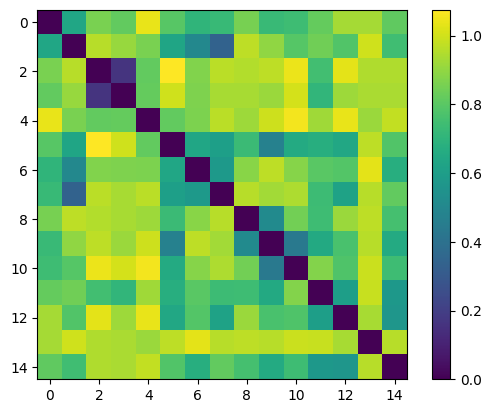

In [224]:
matrix = np.vstack(embeddings)

# Расчет евклидового расстояния между векторами
distances = cdist(matrix, matrix, 'cosine')

# Построение графика
plt.imshow(distances)
plt.colorbar()
plt.show()

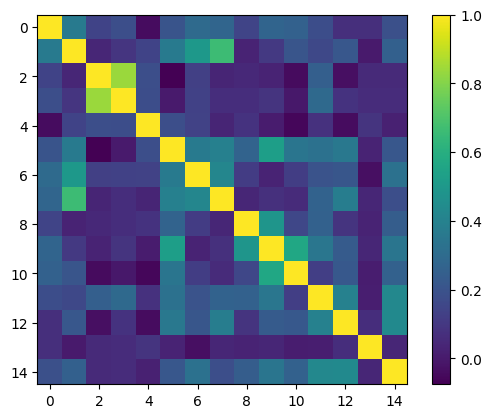

In [225]:
distances = similarities

# Построение графика
plt.imshow(distances)
plt.colorbar()
plt.show()

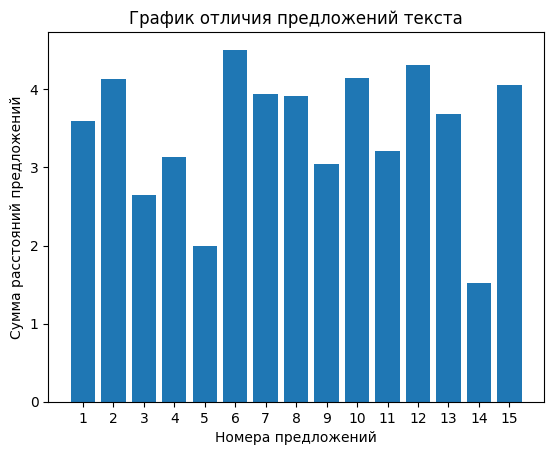

In [226]:

column_sums = np.sum(np.array(distances),axis=0)

# Построение столбчатой диаграммы с измененной нумерацией по оси x
plt.bar(np.arange(1, len(column_sums) + 1), column_sums)
plt.xlabel('Номера предложений')
plt.ylabel('Сумма расстояний предложений')
plt.title('График отличия предложений текста')
plt.xticks(np.arange(1, len(column_sums) + 1))
plt.show()

In [227]:
import statistics as stat

mean=stat.mean(column_sums)
up_bound=mean + stat.stdev(column_sums)
low_bound=mean - stat.stdev(column_sums)
print(mean,low_bound,up_bound)
rez=[list(column_sums).index(i) for i in column_sums if  i<low_bound ]
#rez=[list(column_sums).index(i) for i in column_sums if i <low_bound  or i>up_bound]
rez

3.4555418 2.588264016315061 4.322819681957644


[4, 13]

In [228]:
for i in rez:
    print(real_parts1[i])

ферма коробка 3 на 3 с размером 10
есть пряники


## Метод сравнение каждого с каждым

In [229]:
real_parts=['Здание котельной одноэтажное с встроенным двухэтажным АБК и одноэтажными пристройками, включающими оперативные бункеры с гидравлическими толкателями, помещение топливоподачи и навес для твердого топлива.',
 'В осях 1-6, А-Ж имеет простую форму в плане с общими размерами 30,0х30,0 м  и  высотой до низа несущих конструкций покрытия  10,17 м с пристройкой помещений приемки топлива с отметкой до низа строительных конструкций 7,500 м.',
 'Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.',
 'Проектируемая ферма состоит из двух коровников на 550 голов и доильно-молочного блока.',
 'ферма коробка 3 на 3 с размером 10',
 'Каркас котельной смешанный из сборных железобетонных колонн с покрытием из металлических конструкций. Шаг колонн 6 м и 9 м, пролеты 24 м и 6 м.',
 'АБК в осях 1-2, А-Г запроектирован двухэтажным без подвала с размерами в плане 6,0х12,0 м с высотой этажа 3,3 м. ',
 'Пристройки в осях 6-14, А-Е имеют сложную форму в плане с общими габаритными размерами 32,8х24,1 м. Отметка низа покрытия помещений приемки топлива плюс 6,900.',
 'Наружные стены  и кровля котельной с АБК предусмотрены из легких трехслойных металлических панелей типа «Сэндвич».',
 'Сопряжение металлических надколонников со сборными железобетонными колоннами и монолитными стенами является жёстким. Соединение металлических ферм и балок с надколонниками выполнено шарнирным.',
 'Устойчивость каркаса достигается за счет жесткого соединения монолитных фундаментов с железобетонными сборными колоннами с шарнирным опиранием стропильных конструкций в поперечном направлении, вертикальными связями и распорками по верху колонн - в продольном направлении. Горизонтальная жесткость обеспечивается за счет связей по верхним и нижним поясам ферм.',
 'Балки покрытия выполнены из горячекатаных металлоконструкций двутаврового сечения, стропильные фермы по серии 1.460.3-23.98 из замкнутых гнутосварных профилей.',
 'Сборные железобетонные колонны по оси 1 сечением 400х400 по серии 1.423.1-3/88, в осях 2-6 сечением 500х400 по серии 1.423.1-5/88.',
 'есть пряники',
 'Перекрытия в осях 1-2, Б-Г выполнены из многопустотных железобетонных плит по серии 1.041-3 с монолитными участками по сборным железобетонным ригелям по серии 1.020-1/87.']

In [230]:
data = real_parts

In [231]:
def generate_seq_of_similarity_inc(data:list)->list:
    results,results_values=[],[]
    embedder = SentenceTransformer('distiluse-base-multilingual-cased')
    for i in range(len(data)):
        SENTENCE_NUM=i
        sentence_embeddings = embedder.encode(data, convert_to_tensor=True)
        given_sentence_embedding = sentence_embeddings[SENTENCE_NUM]
        cosine_similarities_bert = util.pytorch_cos_sim(given_sentence_embedding.reshape(1, -1), sentence_embeddings).numpy().flatten()
        results_values.append(cosine_similarities_bert)
        results.append(cosine_similarities_bert.argsort())
    return results,results_values

In [232]:
results,results_values=generate_seq_of_similarity_inc(data)

In [237]:
def get_frequence(results,results_values,isPrint=False):
    sorts=[]
    for j in range(len(results)):
        sorts.append([i for i in results[j] if results_values[j][i]<0.1])
    flat_arr = [val for arr in sorts for val in arr]
    freq_dict = {val: flat_arr.count(val) for val in set(flat_arr)}
    sorted_freq_list=sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    if isPrint:
        global data
        print("\nЧастота встречаемости элементов (отсортированная, только >50%):")
        for val, count in sorted_freq_list: 
            if count > len(data)*0.5:
                print(f"{val}: {count}")
                print(data[val])
    return sorted_freq_list

In [239]:
sorted_freq_list=get_frequence(results,results_values,True)


Частота встречаемости элементов (отсортированная, только >50%):
13: 14
есть пряники
2: 9
Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.
3: 9
Проектируемая ферма состоит из двух коровников на 550 голов и доильно-молочного блока.
4: 9
ферма коробка 3 на 3 с размером 10


In [240]:
def get_frequence(results,results_values,isPrint=False):
    sorts=[]
    for j in range(len(results)):
        sorts.append([i for i in results[j] if results_values[j][i]<np.mean(results_values)])
    flat_arr = [val for arr in sorts for val in arr]
    freq_dict = {val: flat_arr.count(val) for val in set(flat_arr)}
    sorted_freq_list=sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    if isPrint:
        global data
        data_stat=[i[1] for i in sorted_freq_list]
        print("\nЧастота встречаемости элементов (статистический анализ):")
        for val, count in sorted_freq_list: 
            if count >= round(stat.mean(data_stat)+stat.stdev(data_stat)):
                print(f"{val}: {count}")
                print(data[val])
    return sorted_freq_list

In [242]:
sorted_freq_list=get_frequence(results,results_values,True)


Частота встречаемости элементов (статистический анализ):
4: 14
ферма коробка 3 на 3 с размером 10
13: 14
есть пряники
2: 12
Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.
3: 12
Проектируемая ферма состоит из двух коровников на 550 голов и доильно-молочного блока.


In [243]:
# подумать как лучше 

a=[i[1] for i in sorted_freq_list]
stat.mean(a)+stat.stdev(a)
stat.mean(set(a))+stat.stdev(set(a))

12.248568051331986

## Пробуем на записках из ENECA

In [244]:
real_parts=['Здание котельной одноэтажное с встроенным двухэтажным АБК и одноэтажными пристройками, включающими оперативные бункеры с гидравлическими толкателями, помещение топливоподачи и навес для твердого топлива.',
 'В осях 1-6, А-Ж имеет простую форму в плане с общими размерами 30,0х30,0 м  и  высотой до низа несущих конструкций покрытия  10,17 м с пристройкой помещений приемки топлива с отметкой до низа строительных конструкций 7,500 м.',
'Подземный железобетонный монолитный резервуар для технологических жидкостей с отметками дна минус 4,550 и минус 2,800, также является опорной конструкцией стальных колонн каркаса'
 'Каркас котельной смешанный из сборных железобетонных колонн с покрытием из металлических конструкций. Шаг колонн 6 м и 9 м, пролеты 24 м и 6 м.',
 'АБК в осях 1-2, А-Г запроектирован двухэтажным без подвала с размерами в плане 6,0х12,0 м с высотой этажа 3,3 м. ',
 'Пристройки в осях 6-14, А-Е имеют сложную форму в плане с общими габаритными размерами 32,8х24,1 м. Отметка низа покрытия помещений приемки топлива плюс 6,900.',
 'Наружные стены  и кровля котельной с АБК предусмотрены из легких трехслойных металлических панелей типа «Сэндвич».',
 'Сопряжение металлических надколонников со сборными железобетонными колоннами и монолитными стенами является жёстким. Соединение металлических ферм и балок с надколонниками выполнено шарнирным.',
 'Устойчивость каркаса достигается за счет жесткого соединения монолитных фундаментов с железобетонными сборными колоннами с шарнирным опиранием стропильных конструкций в поперечном направлении, вертикальными связями и распорками по верху колонн - в продольном направлении. Горизонтальная жесткость обеспечивается за счет связей по верхним и нижним поясам ферм.',
 'Балки покрытия выполнены из горячекатаных металлоконструкций двутаврового сечения, стропильные фермы по серии 1.460.3-23.98 из замкнутых гнутосварных профилей.',
 'Сборные железобетонные колонны по оси 1 сечением 400х400 по серии 1.423.1-3/88, в осях 2-6 сечением 500х400 по серии 1.423.1-5/88.',
 'Перекрытия в осях 1-2, Б-Г выполнены из многопустотных железобетонных плит по серии 1.041-3 с монолитными участками по сборным железобетонным ригелям по серии 1.020-1/87.']

In [245]:
data = real_parts

In [248]:
def generate_seq_of_similarity_inc(data:list)->list:
    results,results_values=[],[]
    embedder = SentenceTransformer('distiluse-base-multilingual-cased')
    for i in range(len(data)):
        SENTENCE_NUM=i
        sentence_embeddings = embedder.encode(data, convert_to_tensor=True)
        given_sentence_embedding = sentence_embeddings[SENTENCE_NUM]
        cosine_similarities_bert = util.pytorch_cos_sim(given_sentence_embedding.reshape(1, -1), sentence_embeddings).numpy().flatten()
        results_values.append(cosine_similarities_bert)
        results.append(cosine_similarities_bert.argsort())
    return results,results_values

In [249]:
results,results_values=generate_seq_of_similarity_inc(data)

In [255]:
def get_frequence(results,results_values,isPrint=False):
    sorts=[]
    for j in range(len(results)):
        sorts.append([i for i in results[j] if results_values[j][i]>np.mean(results_values)])
    flat_arr = [val for arr in sorts for val in arr]
    freq_dict = {val: flat_arr.count(val) for val in set(flat_arr)}
    sorted_freq_list=sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    if isPrint:
        global data
        data_stat=[i[1] for i in sorted_freq_list]
        print("\nЧастота встречаемости элементов (статистический анализ):")
        for val, count in sorted_freq_list: 
            if count >= round(stat.mean(data_stat)+stat.stdev(data_stat)):
                print(f"{val}: {count}")
                print(data[val])
    return sorted_freq_list

In [256]:
sorted_freq_list=get_frequence(results,results_values,True)
sorted_freq_list


Частота встречаемости элементов (статистический анализ):
2: 7
Подземный железобетонный монолитный резервуар для технологических жидкостей с отметками дна минус 4,550 и минус 2,800, также является опорной конструкцией стальных колонн каркасаКаркас котельной смешанный из сборных железобетонных колонн с покрытием из металлических конструкций. Шаг колонн 6 м и 9 м, пролеты 24 м и 6 м.
6: 6
Сопряжение металлических надколонников со сборными железобетонными колоннами и монолитными стенами является жёстким. Соединение металлических ферм и балок с надколонниками выполнено шарнирным.


[(2, 7),
 (6, 6),
 (4, 5),
 (8, 5),
 (9, 5),
 (10, 5),
 (1, 4),
 (3, 3),
 (7, 3),
 (0, 2),
 (5, 2)]

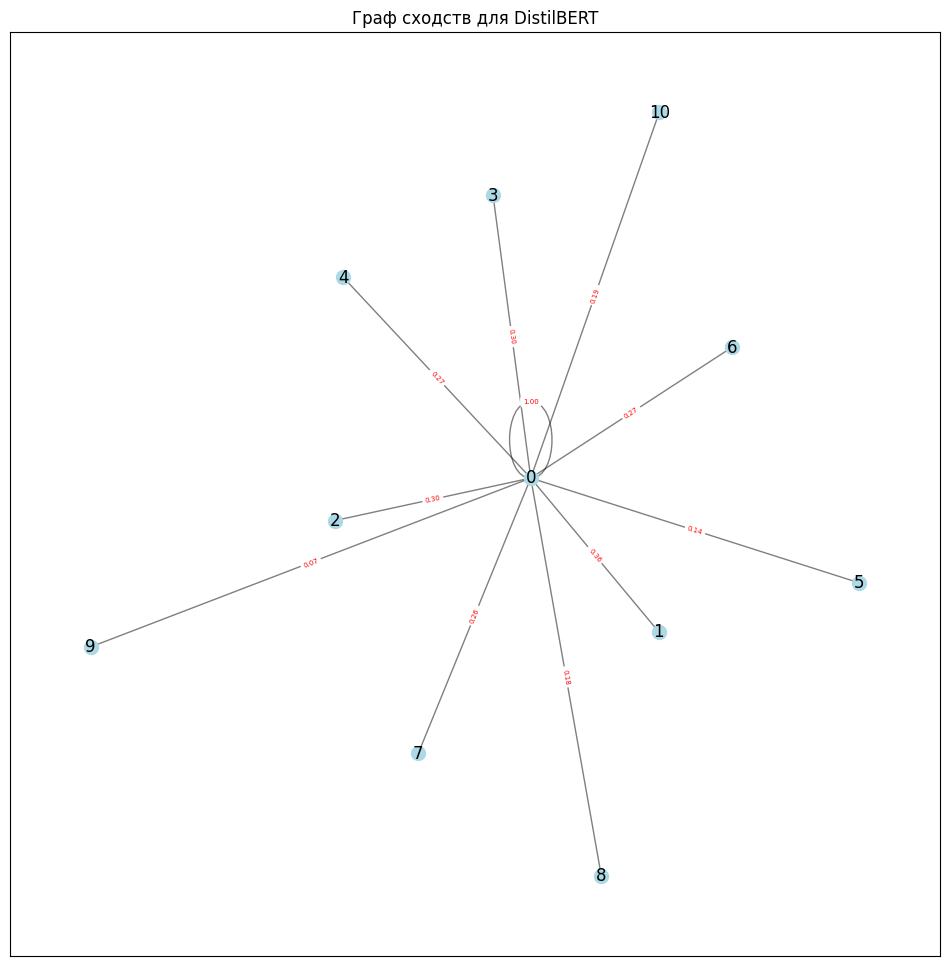

In [257]:
import networkx as nx
SENTENCE_NUM=0
cosine_similarities_bert=results_values[0]
data=real_parts

G = nx.Graph()
edges = [(SENTENCE_NUM, idx, {'weight': cosine_similarities_bert[idx]}) for idx in range(len(data))]
G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_labels(G, pos, {i: str(i) for i in range(len(G.nodes()))})
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}, font_color='red', font_size=5)
plt.title('Граф сходств для DistilBERT')
plt.show()

In [363]:
real_parts=['По генезису это воды спорадического распространения и грунтовые воды, водовмещающими породами которых служат песчаные прослойки в глинистых грунтах и пески мелкие.',
'Во влагообильные периоды года возможно появление вод спорадического распостранения в песчаных прослойках и линзах в любом месте, на любой глубине глинистого разреза в пределах исследуемой площадки, скопление вод типа «верховодки» в песчаных прослойках насыпных грунтов.',
'Участки наружных стен в местах расположения ворот выполнены из керамического полнотелого кирпича на цементно-песчаном растворе толщиной 380 мм. Поверхность стен оштукатурена и окрашена краской.',
'По данным химического анализа к бетону марки W4, W6-W8, W10-W14, W16-W20 по водонепроницаемости вода класса XA0 (неагрессивная), к арматуре ж/б конструкций при постоянном погружении вода класса XA0 (неагрессивная), при периодическом смачивании вода класса XA1 (слабоагрессивная), к металлическим конструкциям XA2 (агрессивная) согласно СН 2.01.07-2020.'
]

In [364]:
data = real_parts

In [365]:
def generate_seq_of_similarity_inc(data:list)->list:
    results,results_values=[],[]
    embedder = SentenceTransformer('distiluse-base-multilingual-cased')
    for i in range(len(data)):
        SENTENCE_NUM=i
        sentence_embeddings = embedder.encode(data, convert_to_tensor=True)
        given_sentence_embedding = sentence_embeddings[SENTENCE_NUM]
        cosine_similarities_bert = util.pytorch_cos_sim(given_sentence_embedding.reshape(1, -1), sentence_embeddings).numpy().flatten()
        results_values.append(cosine_similarities_bert)
        results.append(cosine_similarities_bert.argsort())
    return results,results_values

In [366]:
results,results_values=generate_seq_of_similarity_inc(data)

d:\Eneca\task2\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [367]:
def get_frequence(results,results_values,isPrint=False):
    sorts=[]
    for j in range(len(results)):
        sorts.append([i for i in results[j] if results_values[j][i]<np.mean(results_values)])
    flat_arr = [val for arr in sorts for val in arr]
    freq_dict = {val: flat_arr.count(val) for val in set(flat_arr)}
    sorted_freq_list=sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    if isPrint:
        global data
        data_stat=[i[1] for i in sorted_freq_list]
        find=[]
        print("\nЧастота встречаемости элементов (статистический анализ):")
        for val, count in sorted_freq_list: 
            if count >= round(stat.mean(data_stat)+stat.stdev(data_stat)):
                print(f"{val}: {count}")
                print(data[val])
                find.append(data[val])
            
    return sorted_freq_list,find

In [368]:
sorted_freq_list,find=get_frequence(results,results_values,True)
sorted_freq_list


Частота встречаемости элементов (статистический анализ):
2: 3
Участки наружных стен в местах расположения ворот выполнены из керамического полнотелого кирпича на цементно-песчаном растворе толщиной 380 мм. Поверхность стен оштукатурена и окрашена краской.
3: 3
По данным химического анализа к бетону марки W4, W6-W8, W10-W14, W16-W20 по водонепроницаемости вода класса XA0 (неагрессивная), к арматуре ж/б конструкций при постоянном погружении вода класса XA0 (неагрессивная), при периодическом смачивании вода класса XA1 (слабоагрессивная), к металлическим конструкциям XA2 (агрессивная) согласно СН 2.01.07-2020.


[(2, 3), (3, 3), (0, 2), (1, 2)]

In [369]:
find

['Участки наружных стен в местах расположения ворот выполнены из керамического полнотелого кирпича на цементно-песчаном растворе толщиной 380 мм. Поверхность стен оштукатурена и окрашена краской.',
 'По данным химического анализа к бетону марки W4, W6-W8, W10-W14, W16-W20 по водонепроницаемости вода класса XA0 (неагрессивная), к арматуре ж/б конструкций при постоянном погружении вода класса XA0 (неагрессивная), при периодическом смачивании вода класса XA1 (слабоагрессивная), к металлическим конструкциям XA2 (агрессивная) согласно СН 2.01.07-2020.']

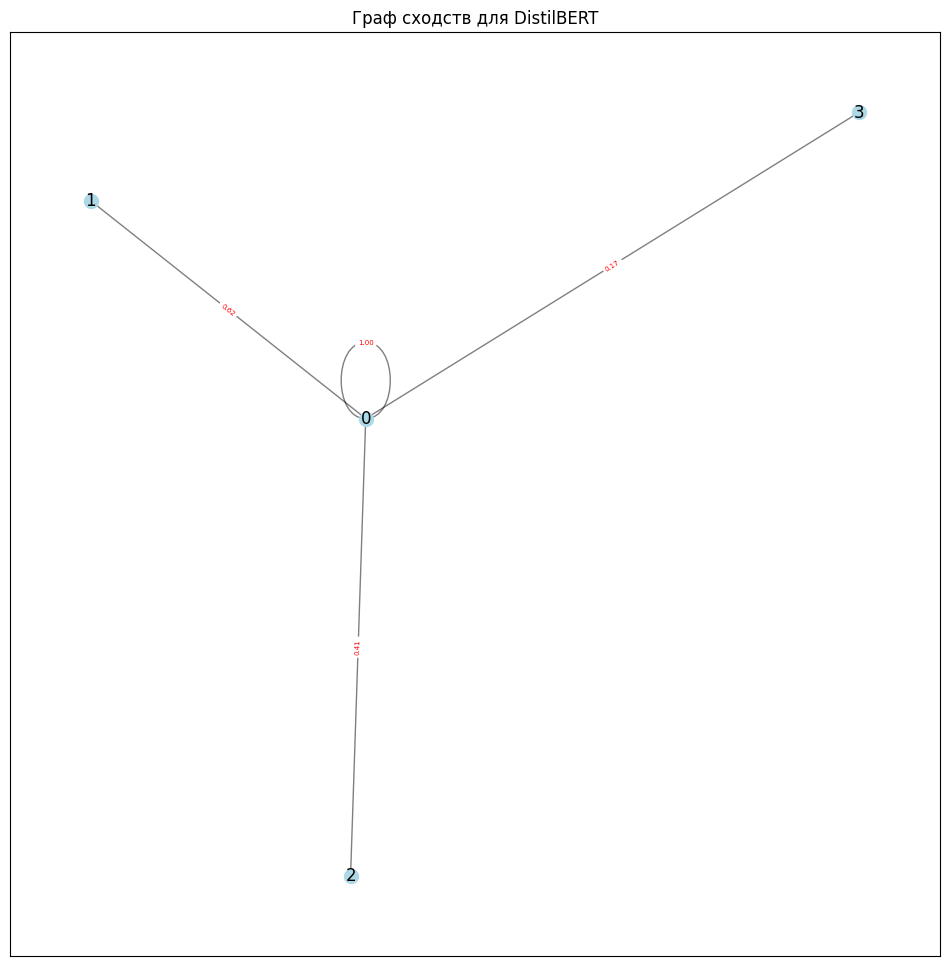

In [273]:
import networkx as nx
SENTENCE_NUM=0
cosine_similarities_bert=results_values[0]
data=real_parts

G = nx.Graph()
edges = [(SENTENCE_NUM, idx, {'weight': cosine_similarities_bert[idx]}) for idx in range(len(data))]
G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_labels(G, pos, {i: str(i) for i in range(len(G.nodes()))})
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}, font_color='red', font_size=5)
plt.title('Граф сходств для DistilBERT')
plt.show()

In [370]:
find

['Участки наружных стен в местах расположения ворот выполнены из керамического полнотелого кирпича на цементно-песчаном растворе толщиной 380 мм. Поверхность стен оштукатурена и окрашена краской.',
 'По данным химического анализа к бетону марки W4, W6-W8, W10-W14, W16-W20 по водонепроницаемости вода класса XA0 (неагрессивная), к арматуре ж/б конструкций при постоянном погружении вода класса XA0 (неагрессивная), при периодическом смачивании вода класса XA1 (слабоагрессивная), к металлическим конструкциям XA2 (агрессивная) согласно СН 2.01.07-2020.']

In [ ]:
from docx import Document
from docx.shared import RGBColor
from docx.enum.text import WD_COLOR_INDEX


document = Document('input.docx')

# Список предложений, которые нужно выделить
sentences_to_highlight = find

# Проходим по всем абзацам в документе
for paragraph in document.paragraphs:
    # Проверяем, содержит ли абзац какое-либо предложение из списка
    for sentence in sentences_to_highlight:
        if sentence in paragraph.text:
            # Если предложение найдено, выделяем его
            for run in paragraph.runs:
                if run.text in sentence:
                    #run.font.color.rgb = RGBColor(255, 0, 0)
                    run.font.highlight_color = WD_COLOR_INDEX.YELLOW

# Сохраняем документ 
document.save('highlighted_output.docx')

### Финальный результат

In [95]:
from docx import Document
from docx.shared import RGBColor
from docx.enum.text import WD_COLOR_INDEX

import numpy as np

from sentence_transformers import SentenceTransformer, util
import statistics as stat

In [96]:
def load_data_from_docx(file_name):
    document = Document(file_name)
    words_to_delete=["Характеристики сооружения и основные решения","Характеристики существующего сооружения и основные решения","Мероприятия по обеспечению пожарной безопасности","Антикоррозионная защита","Таблица"]
    rez,found_start=[],False
    for paragraph in document.paragraphs:
        if 'Исходные данные' in paragraph.text:
            found_start = True
        elif found_start:
            rez.append(paragraph.text)
    return [i for i in rez if i.strip() and not any(word in i for word in words_to_delete)]

In [97]:
real_parts=load_data_from_docx("П-07.22-6.1-КР-ТЧ.docx")
len(real_parts)

85

In [98]:
real_parts.append('Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.')

In [99]:
len(real_parts)

86

In [100]:
data = real_parts

In [101]:
def generate_seq_of_similarity_inc(data:list)->list:
    results,results_values=[],[]
    embedder = SentenceTransformer('distiluse-base-multilingual-cased')
    for i in range(len(data)):
        SENTENCE_NUM=i
        sentence_embeddings = embedder.encode(data, convert_to_tensor=True)
        given_sentence_embedding = sentence_embeddings[SENTENCE_NUM]
        cosine_similarities_bert = util.pytorch_cos_sim(given_sentence_embedding.reshape(1, -1), sentence_embeddings).numpy().flatten()
        results_values.append(cosine_similarities_bert)
        results.append(cosine_similarities_bert.argsort())
    return results,results_values

In [102]:
results,results_values=generate_seq_of_similarity_inc(data)

d:\Eneca\task2\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [105]:
def get_frequence(results,results_values,isPrint=False):
    sorts=[]
    for j in range(len(results)):
        sorts.append([i for i in results[j] if results_values[j][i]<np.mean(results_values)])
    flat_arr = [val for arr in sorts for val in arr]
    freq_dict = {val: flat_arr.count(val) for val in set(flat_arr)}
    sorted_freq_list=sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    global data
    data_stat=[i[1] for i in sorted_freq_list]
    find,mark=[],False
    if isPrint:
        print("\nЧастота встречаемости элементов (статистический анализ):")
        mark=True
    for val, count in sorted_freq_list: 
        if count >= round(stat.mean(data_stat)+2*stat.stdev(data_stat)):
            if mark:
                print(f"{val}: {count}")
                print(data[val])
            find.append(data[val])
            
    return sorted_freq_list,find

In [106]:
sorted_freq_list,find=get_frequence(results,results_values,True)
sorted_freq_list


Частота встречаемости элементов (статистический анализ):
85: 83
Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.
77: 81
Цветовое решение окраски принимать по чертежам АР.


[(85, 83),
 (77, 81),
 (2, 77),
 (36, 77),
 (78, 75),
 (69, 73),
 (44, 72),
 (75, 72),
 (0, 69),
 (1, 69),
 (13, 69),
 (29, 69),
 (46, 69),
 (55, 69),
 (26, 68),
 (37, 68),
 (28, 67),
 (34, 66),
 (70, 66),
 (14, 64),
 (45, 64),
 (72, 63),
 (66, 62),
 (35, 61),
 (50, 61),
 (47, 60),
 (6, 58),
 (54, 57),
 (33, 56),
 (40, 56),
 (43, 56),
 (83, 55),
 (38, 54),
 (39, 54),
 (48, 54),
 (49, 54),
 (51, 54),
 (32, 53),
 (53, 53),
 (76, 53),
 (42, 51),
 (80, 51),
 (67, 50),
 (27, 49),
 (52, 49),
 (23, 48),
 (31, 48),
 (58, 48),
 (81, 47),
 (82, 47),
 (59, 46),
 (71, 46),
 (22, 45),
 (16, 43),
 (19, 43),
 (41, 43),
 (56, 43),
 (65, 43),
 (68, 43),
 (5, 42),
 (10, 42),
 (17, 42),
 (61, 42),
 (73, 42),
 (57, 41),
 (62, 41),
 (21, 40),
 (24, 40),
 (25, 40),
 (60, 40),
 (30, 39),
 (84, 39),
 (4, 38),
 (9, 38),
 (8, 36),
 (64, 36),
 (3, 35),
 (12, 35),
 (18, 34),
 (63, 33),
 (74, 33),
 (79, 32),
 (20, 30),
 (7, 27),
 (15, 27),
 (11, 26)]

In [107]:
find

['Проектируемая молочно-товарная ферма состоит из двух коровников на 350 голов и доильно-молочного блока.',
 'Цветовое решение окраски принимать по чертежам АР.']

In [68]:
def get_review(file_name,find):
    document = Document(file_name)
    # Список предложений, которые нужно выделить
    sentences_to_highlight = find

    # Проходим по всем абзацам в документе
    for paragraph in document.paragraphs:
        # Проверяем, содержит ли абзац какое-либо предложение из списка
        for sentence in sentences_to_highlight:
            if sentence in paragraph.text:
                # Если предложение найдено, выделяем его
                for run in paragraph.runs:
                    if run.text in sentence:
                        #run.font.color.rgb = RGBColor(255, 0, 0)
                        run.font.highlight_color = WD_COLOR_INDEX.YELLOW

    # Сохраняем документ 
    return document.save(f'{file_name}_review.docx')